In [ ]:
!pip install -q pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.7 MB/s eta 0:00:00


# Variational Quantum Autoencoder

A variational quantum autoencoder (VQAE) is a type of quantum machine learning algorithm that combines the power of quantum computing and neural networks to perform data compression and reconstruction. It is a natural extension of classical autoencoders, which are widely used in deep learning to compress and decompress high-dimensional data. In contrast to classical autoencoders, VQAEs use quantum circuits to encode and decode data, and can therefore take advantage of the unique properties of quantum mechanics, such as superposition and entanglement, to achieve better data compression and higher accuracy in reconstruction.

The VQAE architecture consists of three main components: an encoder quantum circuit, a decoder quantum circuit, and a classical neural network that acts as an optimizer. The encoder circuit maps the input data into a lower-dimensional quantum state, which is then fed into the decoder circuit to reconstruct the original data. The optimization process is used to minimize the difference between the input and output data by adjusting the parameters of the quantum circuits and the neural network.

One of the key advantages of VQAEs is their ability to learn from a limited amount of training data, which is particularly useful in situations where data is scarce or expensive to obtain. VQAEs can also be used for unsupervised learning, which means they can identify patterns and features in data without the need for explicit labels.

VQAEs are still in the early stages of development, and there are many challenges that need to be overcome before they can be applied to real-world problems. However, they hold great promise for the future of quantum machine learning, and could potentially lead to breakthroughs in areas such as drug discovery, materials science, and optimization.


### Download dataset

In [ ]:
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
import pennylane as qml
import pennylane.numpy as np
from pennylane.templates.embeddings import AmplitudeEmbedding
import matplotlib.pyplot as plt

In [ ]:
X, y = datasets.load_wine(return_X_y=True)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)[0]

In [ ]:
# # wrong encoding
# n_qubits = 4
# dev = qml.device('default.qubit', wires=n_qubits)

# @qml.qnode(dev)
# def circuit(feature_vector):
#   U = np.eye(2 ** n_qubits, dtype=complex)
#   for i in range(len(feature_vector)):
#     #print(feature_vector[i])
#     U[i, i] = np.exp(1j * feature_vector[i] * np.pi)
#   #print(U)
#   qml.QubitUnitary(U, wires=range(n_qubits))
#   return qml.state()

# print(circuit(X_scaled[0]))
# print(circuit(X_scaled[1]))

In [ ]:
# correct encoding
n_qubits = 4
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev)
def circuit(feature_vector):
  qml.AmplitudeEmbedding(features=np.exp(1j * np.pi * feature_vector), wires=range(n_qubits), pad_with=0.0, normalize=True)
  return qml.state()

In [ ]:
def phase_embedding_layer(x):
  qml.AmplitudeEmbedding(features=np.exp(1j * np.pi * x), wires=range(n_qubits), pad_with=0.0, normalize=True)
  #qml.AmplitudeEmbedding(features=x, wires=range(n_qubits), pad_with=0.0, normalize=True)

def encoding_layer(params):
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)
    for i in range(n_qubits-1):
      qml.CNOT(wires=[i, (i+1)%n_qubits])

def decoding_layer(params):
    for i in range(n_qubits-1):
      k = n_qubits - i - 1
      qml.CNOT(wires=[k, (k+1)%n_qubits])
    for i in range(n_qubits):
        qml.RY(-params[i], wires=i)

In [ ]:
n_qubits = 4
n_layers = 10
measure_qubits = [0,1]
dev = qml.device("default.qubit", wires=n_qubits)

In [ ]:
@qml.qnode(dev)
def encoding_circuit(params, x, mqubits=None):
    phase_embedding_layer(x)
    for i in range(n_layers):
        encoding_layer(params[i])
    if mqubits is None:
        for i in range(len(measure_qubits)):
            qml.measure(i)
        return qml.state()
    
    return [
        qml.expval(qml.PauliZ(wires=measure_qubits[i]))
        for i in range(len(measure_qubits))
    ]

In [ ]:
opt = qml.AdamOptimizer()

def loss_fn(params, X, measure_qubits):
    val = encoding_circuit(params, X, mqubits=measure_qubits)
    return np.sum(np.abs(1 - val))

params = np.array([
    [np.random.uniform(0, 2 * np.pi) for _ in range(n_qubits)] for _ in range(n_layers)], requires_grad=True)

costs=[]
for i in range(1000):
    params, cost_val = opt.step_and_cost(lambda v: loss_fn(v, X_scaled, measure_qubits), params)
    costs.append(cost_val)
    if (i + 1) % 20 == 0:
        print('Step {}: Cost = {}'.format(i + 1, cost_val))

Step 20: Cost = 0.6403648396144628
Step 40: Cost = 0.2665549105628565
Step 60: Cost = 0.09694793857885897
Step 80: Cost = 0.04408708911920467
Step 100: Cost = 0.026128196859139363
Step 120: Cost = 0.013601760721008826
Step 140: Cost = 0.006574403744542767
Step 160: Cost = 0.0032333779669293516
Step 180: Cost = 0.0015906761358953636
Step 200: Cost = 0.0007104493533709455
Step 220: Cost = 0.00026933528667760775
Step 240: Cost = 8.316991106327443e-05
Step 260: Cost = 2.0006275856632172e-05
Step 280: Cost = 3.5013492308832994e-06
Step 300: Cost = 3.961888113135359e-07
Step 320: Cost = 2.4924684205451797e-08
Step 340: Cost = 2.037975233015743e-09
Step 360: Cost = 4.743956338870703e-10
Step 380: Cost = 4.751521398560499e-11
Step 400: Cost = 5.6632476486129235e-12
Step 420: Cost = 8.546496843564455e-13
Step 440: Cost = 5.762057497804562e-14
Step 460: Cost = 1.7430501486614958e-14
Step 480: Cost = 0.0
Step 500: Cost = 4.440892098500626e-16
Step 520: Cost = 1.9095836023552692e-14
Step 540: Cost

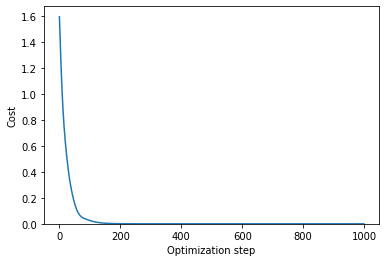

In [ ]:
# Plot cost history
plt.plot(costs)
plt.xlabel("Optimization step")
plt.ylabel("Cost")
plt.ylim(0)
plt.show()

## 2-qubit case (revisited)

In [ ]:
import pennylane as qml
import pennylane.numpy as np
from pennylane.templates.embeddings import AmplitudeEmbedding
import matplotlib.pyplot as plt

def phase_embedding_layer(x):
  qml.AmplitudeEmbedding(features=np.exp(1j * np.pi * x), wires=range(n_qubits), pad_with=0.0, normalize=True)

def encoding_layer(params):
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)
    for i in range(n_qubits):
      qml.CNOT(wires=[i, (i+1)%n_qubits])

def decoding_layer(params):
    for i in range(n_qubits):
      k = n_qubits - i - 1
      qml.CNOT(wires=[k, (k+1)%n_qubits])
    for i in range(n_qubits):
        qml.RY(-params[i], wires=i)


In [ ]:
n_qubits = 2
n_layers = 4
measure_qubits = [0]
dev = qml.device("default.qubit", wires=n_qubits)

In [ ]:
@qml.qnode(dev)
def encoding_circuit(params, x, measure_qubits=None):
  phase_embedding_layer(x)
  for i in range(n_layers):
    encoding_layer(params[i])
  if measure_qubits is None:
    return qml.state()
  if (len(measure_qubits) == 2):
    return qml.expval(qml.PauliZ(wires=measure_qubits[0])), qml.expval(qml.PauliZ(wires=measure_qubits[1]))  
  return qml.expval(qml.PauliZ(wires=measure_qubits))

In [ ]:
xval = np.random.uniform(
    0,
    np.pi,
    2**n_qubits,
)

In [ ]:
opt = qml.AdamOptimizer()

def loss_fn(params, X, measure_qubits):
  val = encoding_circuit(params, X, measure_qubits=measure_qubits)
  return np.mean(np.abs(1-val))


params = np.array([
    [np.random.uniform(0, 2 * np.pi) for _ in range(n_qubits)] for _ in range(n_layers)
], requires_grad=True)
tot_iter = 1000
costs=[]
for i in range(tot_iter):
    params, cost_val = opt.step_and_cost(lambda v: loss_fn(v, xval, measure_qubits), params)
    costs.append(cost_val)
    if (i + 1) % (tot_iter/100) == 0:
        print('Step {}: Cost = {}'.format(i + 1, cost_val))

Step 10: Cost = 0.6543894227818412
Step 20: Cost = 0.5076924248980641
Step 30: Cost = 0.36994695188319215
Step 40: Cost = 0.23911393555013682
Step 50: Cost = 0.13143203186806363
Step 60: Cost = 0.05916281819446545
Step 70: Cost = 0.02009835634174173
Step 80: Cost = 0.004330699212578559
Step 90: Cost = 0.00045411048022003797
Step 100: Cost = 0.00020859785385651808
Step 110: Cost = 0.00023017895684174228
Step 120: Cost = 0.00010566222186758623
Step 130: Cost = 1.9499601922823295e-05
Step 140: Cost = 1.2203590554760169e-06
Step 150: Cost = 2.8693805419477414e-06
Step 160: Cost = 1.9063234716343302e-06
Step 170: Cost = 3.0606388001785945e-07
Step 180: Cost = 7.2981398702154365e-09
Step 190: Cost = 6.228745841330152e-08
Step 200: Cost = 2.7111255018752445e-08
Step 210: Cost = 1.1289157386684678e-09
Step 220: Cost = 1.956557027504857e-09
Step 230: Cost = 1.1975603841918314e-09
Step 240: Cost = 7.2065797773746e-11
Step 250: Cost = 1.182025588519764e-10
Step 260: Cost = 4.127587160951407e-11
S

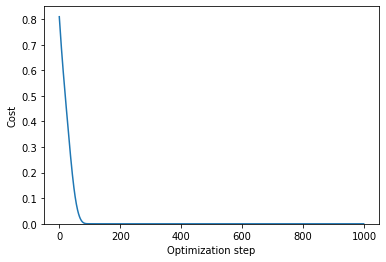

In [ ]:
# Plot cost history
plt.plot(costs)
plt.xlabel("Optimization step")
plt.ylabel("Cost")
plt.ylim(0)
plt.show()

In [ ]:
opt_params = params

In [ ]:
opt_params

tensor([[2.559182  , 4.63126161],
        [3.7084734 , 0.92342611],
        [6.03709028, 6.14763942],
        [4.79766455, 2.86500368]], requires_grad=True)

In [ ]:
n_layers = 4
m_qubits = ['m0']
c_qubits = ['c0']
a_qubits = ['a0']
dev = qml.device("default.qubit", wires=m_qubits+c_qubits+a_qubits)
xval = np.random.uniform(
    0,
    np.pi,
    2**n_qubits,
)
all_qubits = m_qubits+c_qubits
print(all_qubits)

['m0', 'c0']


In [ ]:
n_layers = 4
m_qubits = ['m0']
c_qubits = ['c0']
a_qubits = ['a0']
dev = qml.device("default.qubit", wires=m_qubits+c_qubits+a_qubits)
xval = np.random.uniform(
    0,
    np.pi,
    2**n_qubits,
)

def phase_embedding_layer(x):
  qml.AmplitudeEmbedding(features=np.exp(1j * np.pi * x), wires=m_qubits+c_qubits, pad_with=0.0, normalize=True)
  #qml.AmplitudeEmbedding(features=x, wires=range(n_qubits), pad_with=0.0, normalize=True)

def encoding_layer(params):
  all_qubits = m_qubits+c_qubits
  for i, q in enumerate(all_qubits):
    qml.RY(params[i], wires=q)
  for i, q in enumerate(all_qubits):
    if i + 1 < len(all_qubits):
      qml.CNOT(wires=[q, all_qubits[i+1]])

def decoding_layer(params):
  all_qubits = a_qubits+c_qubits
  for i, q in enumerate(all_qubits):
    k = len(all_qubits) - i - 1
    if k+1 < len(all_qubits):
      qml.CNOT(wires=[all_qubits[k], all_qubits[k+1]])
  for i, q in enumerate(all_qubits):
    qml.RY(-params[i], wires=q)

In [ ]:
opt = qml.AdamOptimizer()

@qml.qnode(dev)
def encode_loop(params, x):
  phase_embedding_layer(x)
  for i in range(n_layers):
    encoding_layer(params[i])
  return qml.expval(qml.PauliZ(wires=m_qubits))


def loss_fn(params, X):
  e_val = encode_loop(params, X)
  return np.mean(np.abs(1-e_val))


params = np.array([
    [np.random.uniform(0, 2 * np.pi) for _ in range(n_qubits)] for _ in range(n_layers)
], requires_grad=True)
opt_params = np.zeros_like(params)
tot_iter = 1000
costs=[]
for i in range(tot_iter):
  params, cost_val = opt.step_and_cost(lambda v: loss_fn(v, xval), params)
  costs.append(cost_val)
  if (i + 1) % (tot_iter/100) == 0:
    print('Step {}: Cost = {}'.format(i + 1, cost_val))
  opt_params = params
    

Step 10: Cost = 0.3484939799111004
Step 20: Cost = 0.16404906384492834
Step 30: Cost = 0.06312606471793836
Step 40: Cost = 0.01488519104803221
Step 50: Cost = 0.00411525550534575
Step 60: Cost = 0.002330772382092783
Step 70: Cost = 0.0014352682586141752
Step 80: Cost = 0.00037097721340950685
Step 90: Cost = 3.3337248138143316e-05
Step 100: Cost = 2.0237304671821832e-05
Step 110: Cost = 2.0888886968051246e-05
Step 120: Cost = 6.558285374103079e-06
Step 130: Cost = 2.725759027155661e-06
Step 140: Cost = 1.8520907378860585e-06
Step 150: Cost = 7.271250287432807e-07
Step 160: Cost = 4.285697777772768e-07
Step 170: Cost = 2.7842568750546803e-07
Step 180: Cost = 1.373107583191313e-07
Step 190: Cost = 7.500121179671027e-08
Step 200: Cost = 3.7575233702291655e-08
Step 210: Cost = 1.7841932820061857e-08
Step 220: Cost = 7.887282826857245e-09
Step 230: Cost = 3.0709504938997156e-09
Step 240: Cost = 1.1173473257741762e-09
Step 250: Cost = 3.293435524298616e-10
Step 260: Cost = 7.960110348648186e-

In [ ]:
dev = qml.device("default.qubit", wires=m_qubits+c_qubits+a_qubits, shots=10)

@qml.qnode(dev)
def circuit(params, x):
  phase_embedding_layer(x)
  for i in range(n_layers):
    encoding_layer(params[i])
  return qml.sample(wires=m_qubits)

samples = circuit(opt_params, xval)
#post_measurement_state = qml.state(circuit, conditional=samples)


In [ ]:
samples

In [ ]:
from pennylane.measurements.state import density_matrix
def decoding_loop(params, wires):
  all_qubits = wires
  for j in range(n_layers):
    for i, q in enumerate(all_qubits):
      k = len(all_qubits) - i - 1
      if k+1 < len(all_qubits):
        qml.CNOT(wires=[all_qubits[k], all_qubits[k+1]])
      for i, q in enumerate(all_qubits):
        qml.RY(-params[j, i], wires=q)


@qml.qnode(dev)
@qml.defer_measurements
def circuit_cond(params, x):
  phase_embedding_layer(x)
  for i in range(n_layers):
    encoding_layer(params[i])
  m0 = qml.measure(wires=m_qubits)
  print(m0)
  qml.cond(m0, decoding_loop)(params, wires=a_qubits+c_qubits)
  return qml.density_matrix(wires=a_qubits+c_qubits)


dev = qml.device("default.qubit", wires=m_qubits+c_qubits+a_qubits, shots=10)
@qml.qnode(dev)
def embedding_circ(x):
  phase_embedding_layer(x)
  return density_matrix(wires=m_qubits+c_qubits)

print(circuit_cond(opt_params, xval))
print(embedding_circ(xval))
qml.math.fidelity(embedding_circ(xval), circuit_cond(opt_params, xval))

if 4e968209=0 => 0
if 4e968209=1 => 1
[[ 0.37249434+0.j          0.04844388+0.06568472j -0.06529836-0.28655129j
   0.05502985-0.06069934j]
 [ 0.04844388-0.06568472j  0.17896133+0.j         -0.13027919-0.05354502j
  -0.03549408-0.17610925j]
 [-0.06529836+0.28655129j -0.13027919+0.05354502j  0.26820203+0.j
   0.07853045+0.11758317j]
 [ 0.05502985+0.06069934j -0.03549408+0.17610925j  0.07853045-0.11758317j
   0.18034231+0.j        ]]
[[ 0.25      +0.j         -0.03849743+0.24701811j  0.04179864+0.24648098j
   0.24606829-0.04416329j]
 [-0.03849743-0.24701811j  0.25      +0.j          0.23710451-0.07925562j
  -0.08152851-0.23633261j]
 [ 0.04179864-0.24648098j  0.23710451+0.07925562j  0.25      +0.j
  -0.00240036-0.24998848j]
 [ 0.24606829+0.04416329j -0.08152851+0.23633261j -0.00240036+0.24998848j
   0.25      +0.j        ]]
if e08465f3=0 => 0
if e08465f3=1 => 1


/usr/local/lib/python3.8/dist-packages/pennylane/_qubit_device.py:839: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  warnings.warn(


0.14101694680812446

# MNIST test

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from PIL import Image

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape images to 8x8 pixels
X_train_resized = np.zeros((X_train.shape[0], 8, 8))
for i in range(X_train.shape[0]):
    img = Image.fromarray(X_train[i])
    img = img.resize((8, 8), resample=Image.LANCZOS)
    X_train_resized[i] = np.asarray(img)

X_test_resized = np.zeros((X_test.shape[0], 8, 8))
for i in range(X_test.shape[0]):
    img = Image.fromarray(X_test[i])
    img = img.resize((8, 8), resample=Image.LANCZOS)
    X_test_resized[i] = np.asarray(img)

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i in range(10):
    row = i // 5
    col = i % 5
    ax[row, col].imshow(X_train_resized[i], cmap='gray')
    ax[row, col].set_title(str(y_train[i]))
plt.tight_layout()
plt.show()

In [ ]:
n_qubits = 6
n_layers = 4
measure_qubits = [0,1]
dev = qml.device("default.qubit", wires=n_qubits)

def phase_embedding_layer(x):
  #qml.AmplitudeEmbedding(features=np.exp(1j * np.pi * x), wires=range(n_qubits), pad_with=0.0, normalize=True)
  qml.AmplitudeEmbedding(features=x, wires=range(n_qubits), pad_with=0.0, normalize=True)

def encoding_layer(params):
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)
    for i in range(n_qubits):
      qml.CNOT(wires=[i, (i+1)%n_qubits])

def decoding_layer(params):
    for i in range(n_qubits):
      k = n_qubits - i - 1
      qml.CNOT(wires=[k, (k+1)%n_qubits])
    for i in range(n_qubits):
        qml.RY(-params[i], wires=i)

@qml.qnode(dev)
def encoding_circuit(params, x, measure_qubits=None):
  phase_embedding_layer(x)
  for i in range(n_layers):
    encoding_layer(params[i])
  if measure_qubits is None:
    return qml.state()
  if (len(measure_qubits) == 2):
    return qml.expval(qml.PauliZ(wires=measure_qubits[0])), qml.expval(qml.PauliZ(wires=measure_qubits[1]))  
  return qml.expval(qml.PauliZ(wires=measure_qubits))

In [ ]:
np.shape(X_train_resized.reshape(60000, 64))

In [ ]:
opt = qml.AdamOptimizer()

def loss_fn(params, X, measure_qubits):
  val = encoding_circuit(params, X, measure_qubits=measure_qubits)
  return np.mean(np.abs(1-val))


params = np.array([
    [np.random.uniform(0, 2 * np.pi) for _ in range(n_qubits)] for _ in range(n_layers)
], requires_grad=True)
tot_iter = 1000
batch_size = 500
costs=[]
xval = X_train_resized.reshape(60000, 64)
xval = xval[np.random.choice(xval.shape[0], batch_size, replace=False), :]
for i in range(tot_iter):
    xval_batch = xval[np.random.choice(xval.shape[0], 100, replace=False), :]
    params, cost_val = opt.step_and_cost(lambda v: loss_fn(v, xval_batch, measure_qubits), params)
    costs.append(cost_val)
    if (i + 1) % (tot_iter/100) == 0:
        print('Step {}: Cost = {}'.format(i + 1, cost_val))

# Plot cost history
plt.plot(costs)
plt.xlabel("Optimization step")
plt.ylabel("Cost")
plt.ylim(0)
plt.show()

# References

[1] [Quantum autoencoders with enhanced data encoding](https://arxiv.org/abs/2010.06599)

[2] [Quantum neural network autoencoder and classifier applied to an industrial case study
](https://link.springer.com/article/10.1007/s42484-022-00070-4)

[3] [Quantum computing model of an artificial neuron with continuously valued input data
](https://iopscience.iop.org/article/10.1088/2632-2153/abaf98/meta)

# Complete code for 2-1-2 qubits

In [ ]:
n_layers = 4
m_qubits = ['m0']
c_qubits = ['c0', 'c1']
a_qubits = ['a0']
n_qubits = len(m_qubits+c_qubits)
dev = qml.device("default.qubit", wires=m_qubits+c_qubits+a_qubits)
xval = np.random.uniform(
    0,
    np.pi,
    2**n_qubits
) #initial state

dev = qml.device("default.qubit", wires=m_qubits+c_qubits+a_qubits)

def phase_embedding_layer(x):
  qml.AmplitudeEmbedding(features=np.exp(1j * x), wires=m_qubits+c_qubits, pad_with=0.0, normalize=True)

def encoding_layer(params):
  all_qubits = m_qubits+c_qubits
  for i, q in enumerate(all_qubits):
    qml.RY(params[i], wires=q)
  for i, q in enumerate(all_qubits):
    if i + 1 < len(all_qubits):
      qml.CNOT(wires=[q, all_qubits[i+1]])

def decoding_layer(params):
  all_qubits = a_qubits+c_qubits
  for i, q in enumerate(all_qubits):
    k = len(all_qubits) - i - 1
    if k+1 < len(all_qubits):
      qml.CNOT(wires=[all_qubits[k], all_qubits[k+1]])
  for i, q in enumerate(all_qubits):
    qml.RY(-params[i], wires=q)

In [ ]:
## Training
opt = qml.AdamOptimizer()

@qml.qnode(dev)
def encode_loop(params, x):
  phase_embedding_layer(x)
  for i in range(n_layers):
    encoding_layer(params[i])
  return qml.expval(qml.PauliZ(wires=m_qubits))


def loss_fn(params, X):
  e_val = encode_loop(params, X)
  return np.mean(np.abs(1-e_val))

params = np.array([
    [np.random.uniform(0, 2 * np.pi) for _ in range(n_qubits)] for _ in range(n_layers)
], requires_grad=True)
opt_params = np.zeros_like(params)
tot_iter = 1000
costs=[]
for i in range(tot_iter):
  params, cost_val = opt.step_and_cost(lambda v: loss_fn(v, xval), params)
  costs.append(cost_val)
  if (i + 1) % (tot_iter/100) == 0:
    print('Step {}: Cost = {}'.format(i + 1, cost_val))
  opt_params = params

Step 10: Cost = 1.4512629500506753
Step 20: Cost = 1.2535234274987315
Step 30: Cost = 1.026950145148915
Step 40: Cost = 0.808267976761307
Step 50: Cost = 0.6232082238502752
Step 60: Cost = 0.47813304484793906
Step 70: Cost = 0.36940387737019065
Step 80: Cost = 0.28228203103685345
Step 90: Cost = 0.20393866292944807
Step 100: Cost = 0.13522429346954
Step 110: Cost = 0.0811416003823866
Step 120: Cost = 0.04411556726913746
Step 130: Cost = 0.022246406583945944
Step 140: Cost = 0.010893721949160828
Step 150: Cost = 0.005612996134924053
Step 160: Cost = 0.0033876035146054306
Step 170: Cost = 0.0025256306542371654
Step 180: Cost = 0.002196100084764452
Step 190: Cost = 0.002042046138650777
Step 200: Cost = 0.0019357089586041765
Step 210: Cost = 0.0018393274921804093
Step 220: Cost = 0.0017446309594536524
Step 230: Cost = 0.0016513724374392913
Step 240: Cost = 0.0015603421226629832
Step 250: Cost = 0.0014719309578054007
Step 260: Cost = 0.0013862747315611657
Step 270: Cost = 0.0013034531056113

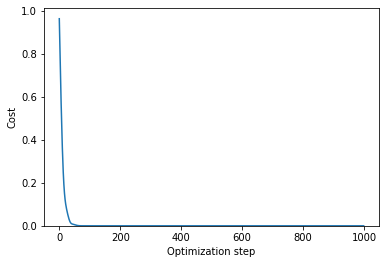

In [ ]:
# Plot cost history
plt.plot(costs)
plt.xlabel("Optimization step")
plt.ylabel("Cost")
plt.ylim(0)
plt.show()

In [ ]:

def decoding_loop(params, wires):
  all_qubits = wires
  for j in range(n_layers):
    for i, q in enumerate(all_qubits):
      k = len(all_qubits) - i - 1
      if k+1 < len(all_qubits):
        qml.CNOT(wires=[all_qubits[k], all_qubits[k+1]])
      for i, q in enumerate(all_qubits):
        qml.RY(-params[-(j+1), i], wires=q)

@qml.qnode(dev)
@qml.defer_measurements
def circuit_cond(params, x):
  phase_embedding_layer(x)
  for i in range(n_layers):
    encoding_layer(params[i])
  m0 = qml.measure(wires=m_qubits)
  qml.cond(m0, decoding_loop)(params, wires=a_qubits+c_qubits)
  print(m0)
  return qml.density_matrix(wires=a_qubits+c_qubits)

@qml.qnode(dev)
def embedding_circ(x):
  phase_embedding_layer(x)
  return qml.density_matrix(wires=m_qubits+c_qubits)

print(circuit_cond(opt_params, xval))
print(embedding_circ(xval))
qml.math.fidelity(embedding_circ(xval), circuit_cond(opt_params, xval))

if dcfbeb46=0 => 0
if dcfbeb46=1 => 1
[[ 5.70138609e-01+6.61666927e-18j -3.95757490e-20+1.90845433e-20j
  -1.71991436e-01-7.71133559e-02j -5.18116744e-20-5.50072092e-20j
   4.65194313e-02+4.28271057e-01j  5.71561866e-20+6.77990851e-20j
   5.13505775e-02-1.46068525e-01j -4.75819030e-20-2.47558792e-20j]
 [-3.95757490e-20-1.90845433e-20j  6.63651247e-20-4.22987569e-37j
  -4.53076827e-20+3.37630405e-20j  3.44018945e-20+1.08831920e-19j
   1.82185976e-20+7.82314883e-20j -3.32806929e-20-1.29742120e-19j
   1.32824094e-20+5.67536145e-22j  4.84946432e-20+6.48989644e-20j]
 [-1.71991436e-01+7.71133559e-02j -4.53076827e-20-3.37630405e-20j
   6.23138356e-02+4.03733602e-19j  3.18816005e-20-9.18017509e-20j
  -7.19585756e-02-1.22902893e-01j -4.32850442e-20+1.05506803e-19j
   4.26558484e-03+5.10092637e-02j -9.03116620e-23-6.89782218e-20j]
 [-5.18116744e-20+5.50072092e-20j  3.44018945e-20-1.08831920e-19j
   3.18816005e-20+9.18017509e-20j  1.96306074e-19-5.01669391e-36j
   1.37735556e-19+1.06764880e-20j -

0.047742917799923026